In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
from matplotlib import rcParams

In [3]:
rcParams["axes.facecolor"] = "white"
rcParams["figure.facecolor"] = "white"

In [4]:
train_df = pd.read_csv("../data/train.csv", header=0)
test_df = pd.read_csv("../data/test.csv", header=0)

In [5]:
nominal = [
    "Product_Info_1", "Product_Info_2", "Product_Info_3", "Product_Info_5", "Product_Info_6", "Product_Info_7",
    "Employment_Info_2", "Employment_Info_3", "Employment_Info_5",
    "InsuredInfo_1", "InsuredInfo_2", "InsuredInfo_3", "InsuredInfo_4", "InsuredInfo_5", "InsuredInfo_6", "InsuredInfo_7",
    "Insurance_History_1", "Insurance_History_2", "Insurance_History_3", "Insurance_History_4", "Insurance_History_7", "Insurance_History_8", "Insurance_History_9",
    "Family_Hist_1",
    "Medical_History_2", "Medical_History_3", "Medical_History_4", "Medical_History_5", "Medical_History_6", "Medical_History_7",
    "Medical_History_8", "Medical_History_9", "Medical_History_11", "Medical_History_12", "Medical_History_13", "Medical_History_14",
    "Medical_History_16", "Medical_History_17", "Medical_History_18", "Medical_History_19", "Medical_History_20", "Medical_History_21",
    "Medical_History_22", "Medical_History_23", "Medical_History_25", "Medical_History_26", "Medical_History_27", "Medical_History_28",
    "Medical_History_29", "Medical_History_30", "Medical_History_31", "Medical_History_33", "Medical_History_34", "Medical_History_35",
    "Medical_History_36", "Medical_History_37", "Medical_History_38", "Medical_History_39", "Medical_History_40", "Medical_History_41",
]
continuous = [
    "Product_Info_4", 
    "Ins_Age", "Ht", "Wt", "BMI",
    "Employment_Info_1", "Employment_Info_4", "Employment_Info_6",
    "Insurance_History_5",
    "Family_Hist_2", "Family_Hist_3", "Family_Hist_4", "Family_Hist_5",
]
discrete = ["Medical_History_1", "Medical_History_10", "Medical_History_15", "Medical_History_24", "Medical_History_32"]
dummy = ["Medical_Keyword_{}".format(x) for x in range(1, 49)]

In [6]:
len(train_df.index), len(test_df.index)

(59381, 19765)

The training set has 59381 samples while the test set has 19765 samples.

<AxesSubplot:xlabel='Ht', ylabel='Count'>

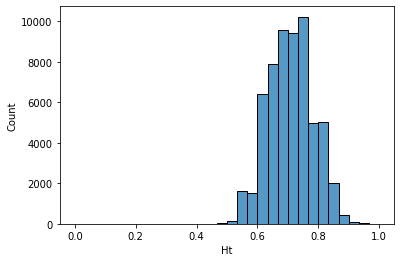

In [17]:
sns.histplot(data=train_df[["Ht"]], x="Ht", bins=30)

The height distribution exhibits a little extent of heterogeneity. (Does explaining this property have anything to do with determining the risk level?)

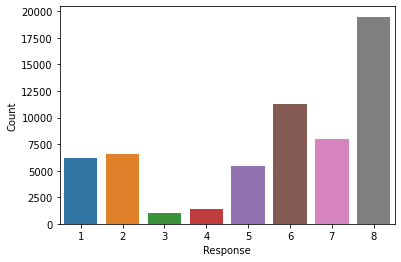

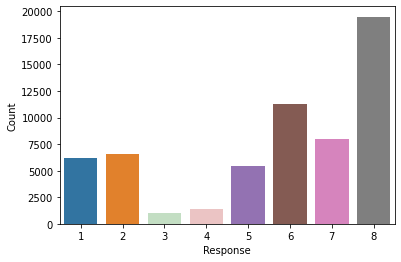

In [18]:
sns.barplot(
    data=train_df["Response"].value_counts().sort_index().to_frame().reset_index().rename(columns={"index": "Response", "Response": "Count"}),
    x="Response",
    y="Count"
)
    
plt.show()
g = sns.barplot(
    data=train_df["Response"].value_counts().sort_index().to_frame().reset_index().rename(columns={"index": "Response", "Response": "Count"}),
    x="Response",
    y="Count"
)

for g in g.get_children()[2:4]:
    g.set_alpha(.3)

There are around 1000 to 1250 responses for risk levels 3 to 4. The majority has risk level 8. If the variable 'Response' is an ordinal variable, it is reasonable to assume that risk level 1 is the highest risk level and risk level 8 is the lowest risk level.

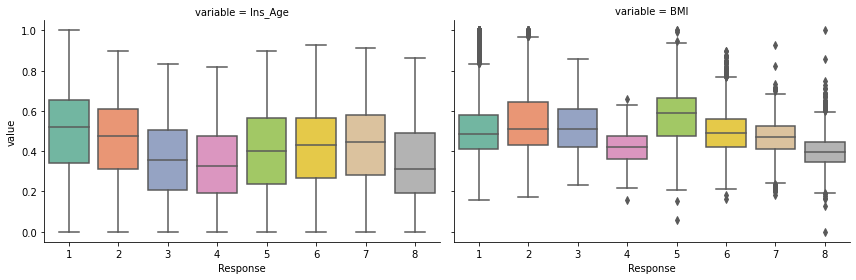

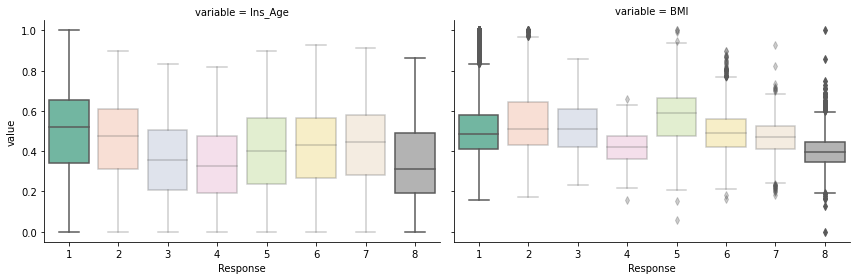

In [200]:
f = pd.melt(train_df.loc[:, ["Response"] + ["Ins_Age", "BMI"]], id_vars=["Response"], value_vars=["Ins_Age", "BMI"])
g = sns.FacetGrid(f, col="variable", col_wrap=2, height=4, aspect=1.5)
g.map(sns.boxplot, "Response", "value", order=list(range(1, 9)), palette="Set2")
plt.show()

f = pd.melt(train_df.loc[:, ["Response"] + ["Ins_Age", "BMI"]], id_vars=["Response"], value_vars=["Ins_Age", "BMI"])
g = sns.FacetGrid(f, col="variable", col_wrap=2, height=4, aspect=1.5)
g.map(sns.boxplot, "Response", "value", order=list(range(1, 9)), palette="Set2")

for ax in g.axes:
    for i, x in enumerate(y for y in ax.get_children() if "PathPatch" in str(y.__class__)):
        if i not in [0, 7]:
            x.set_alpha(.3)
    for i, x in enumerate(y for y in ax.get_children()):
        if i in range(6, 42):
            x.set_alpha(.3)

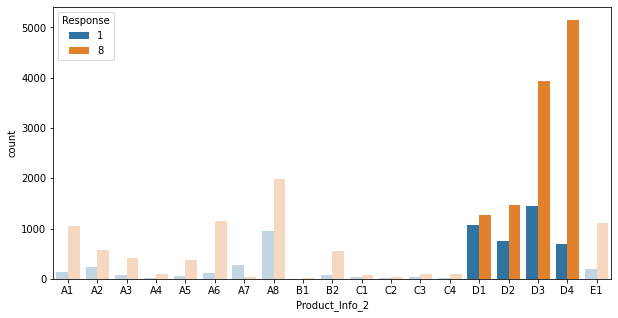

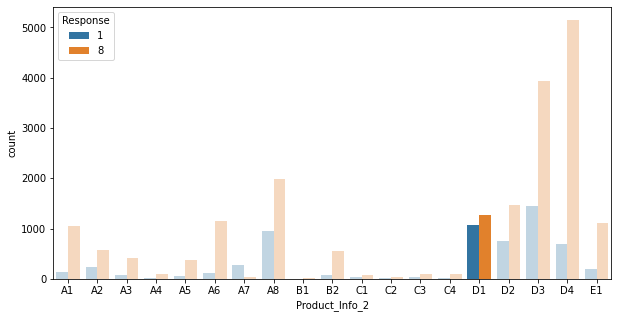

In [307]:
plt.figure(figsize=(10, 5))
g = sns.barplot(
    x="Product_Info_2",
    y="count",
    hue="Response",
    data=train_df.loc[train_df["Response"].isin([1, 8]), ["Response"] + ["Product_Info_2"]].groupby(["Product_Info_2", "Response"]).size().rename("count").to_frame().reset_index(),
    ax=plt.gca()
)
for i in list(range(14)) + [18]:
    g.get_children()[i].set_alpha(.3)
    g.get_children()[19 + i].set_alpha(.3)

plt.figure(figsize=(10, 5))
g = sns.barplot(
    x="Product_Info_2",
    y="count",
    hue="Response",
    data=train_df.loc[train_df["Response"].isin([1, 8]), ["Response"] + ["Product_Info_2"]].groupby(["Product_Info_2", "Response"]).size().rename("count").to_frame().reset_index(),
    ax=plt.gca()
)
for i in list(range(14)) + list(range(15, 19)):
    g.get_children()[i].set_alpha(.3)
    g.get_children()[19 + i].set_alpha(.3)

We now turn our attention to looking at the variable 'Product_Info_2'. How about we only compare risk levels 1 and 8?

Having so many categories, the variable 'Product_Info_2' seems to be related to the type of life insurance plan that Prudential can provide. Most applicants chose the category D. The proportion of risk level 1 is closest to that of risk level 8 relative to all other classes in category D. For someone who chose D1, he/she is more likely to has a risk level 1 than those who chose other classes in category D.

In [19]:
train_df[train_df.columns[np.where(train_df.isnull().sum(axis=0) > 0)]].isnull().sum(axis=0).sort_values().to_frame().reset_index().rename(columns={"index": "Variable with NA", 0: "Count"})

,Variable with NA,Count
0,Employment_Info_1,19
1,Employment_Info_4,6779
2,Medical_History_1,8889
3,Employment_Info_6,10854
4,Family_Hist_4,19184
5,Insurance_History_5,25396
6,Family_Hist_2,28656
7,Family_Hist_3,34241
8,Family_Hist_5,41811
9,Medical_History_15,44596


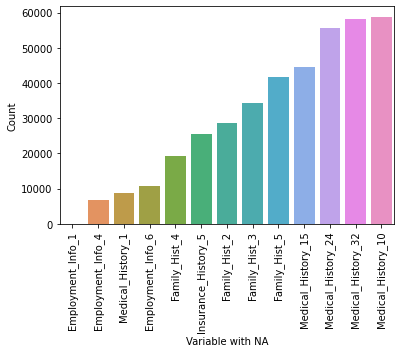

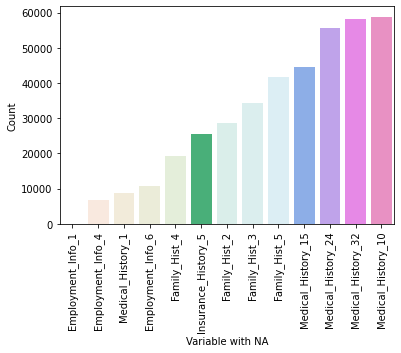

In [20]:
g = sns.barplot(
    data=train_df[train_df.columns[np.where(train_df.isnull().sum(axis=0) > 0)]].isnull().sum(axis=0).sort_values().to_frame().reset_index().rename(columns={"index": "Variable with NA", 0: "Count"}),
    x="Variable with NA",
    y="Count",
#     log=True
)
for tl in g.get_xticklabels():
    tl.set_rotation(90)
plt.show()

g = sns.barplot(
    data=train_df[train_df.columns[np.where(train_df.isnull().sum(axis=0) > 0)]].isnull().sum(axis=0).sort_values().to_frame().reset_index().rename(columns={"index": "Variable with NA", 0: "Count"}),
    x="Variable with NA",
    y="Count",
#     log=True
)
for tl in g.get_xticklabels():
    tl.set_rotation(90)
    
for i, bar in enumerate(g.get_children()[:9]):
    if i != 5:
        bar.set_alpha(.2)
plt.show()

This first histogram indicates the frequency of missing values in each variable. Beware of the variable 'Employment_level_1', which has only 19 missing values. All the other variables have more than 6700 missing values.

Most variables related to medical history have plenty of missing values (the highlighted medical history variables on the rightmost of the figure account for at least 75% of total training samples).

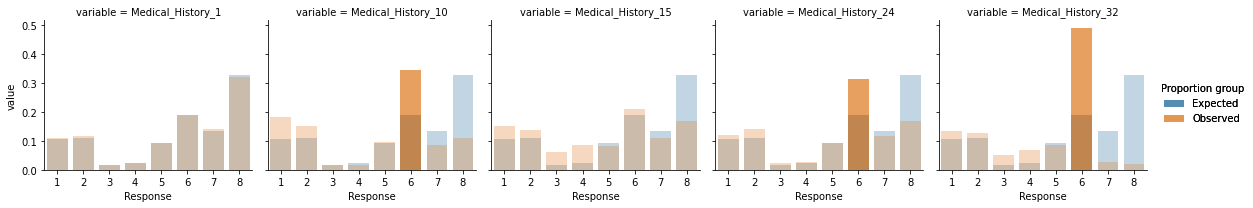

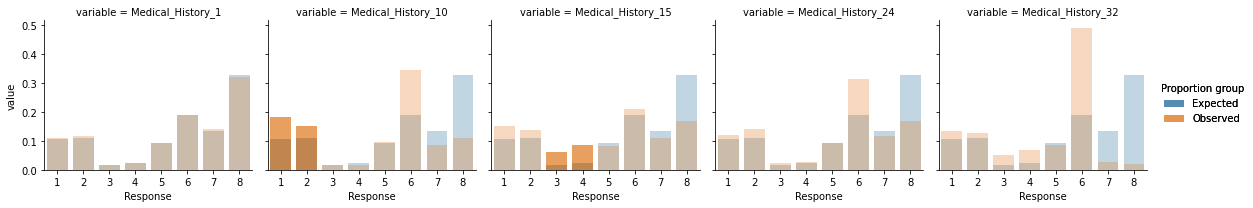

In [26]:
f = pd.concat((
    train_df["Response"],
    train_df[train_df.columns[np.where(train_df.isnull().sum(axis=0) > 0)]].notnull().astype(float)
), axis=1).groupby("Response").sum()
f = f / f.sum(axis=0)
f = f.join(train_df["Response"].value_counts().sort_index().to_frame().rename(columns={"index": "Response", "Response": "Expected"}))
f["Expected"] /= f["Expected"].sum()
f = pd.melt(f.reset_index(), id_vars=["Response", "Expected"], value_vars=f.columns[:-1], value_name="Observed").iloc[:, [0, 2, 1, 3]].reset_index()
# f = pd.melt(f, id_vars=["Response", "Proportion_exp"],
f = pd.merge(
    f.loc[:, f.columns[:3]],
    pd.melt(f, id_vars=["index"], value_vars=["Expected", "Observed"], var_name="proportion_gp"),
    on="index", how="left")
f = f[f.columns[1:]]
for x in [
#         "Employment_Info",
#         "Insurance_History",
#         "Family_Hist",
        "Medical_History"
        ]:
    g = sns.FacetGrid(
        f.loc[f["variable"].str.contains(x)].rename(columns={"proportion_gp": "Proportion group"}), 
        col="variable", 
        hue="Proportion group",
        col_wrap=f["variable"][f["variable"].str.contains(x)].nunique()
#         col_wrap=5
    )
    g.map(sns.barplot, "Response", "value", order=list(range(1, 9)), alpha=.75)
    g.add_legend()
    
    if x == "Medical_History":
        for i in range(5):
            for j, bar in enumerate(g.axes[i].get_children()[:16]):
                if i not in [1, 3, 4] or j not in [5, 5+8]:
                    bar.set_alpha(.3)
    g.add_legend()
plt.show()

for x in [
#         "Employment_Info",
#         "Insurance_History",
#         "Family_Hist",
        "Medical_History"
        ]:
    g = sns.FacetGrid(
        f.loc[f["variable"].str.contains(x)].rename(columns={"proportion_gp": "Proportion group"}), 
        col="variable", 
        hue="Proportion group",
        col_wrap=f["variable"][f["variable"].str.contains(x)].nunique()
#         col_wrap=5
    )
    g.map(sns.barplot, "Response", "value", order=list(range(1, 9)), alpha=.75)
    g.add_legend()
    
    if x == "Medical_History":
        for i in range(5):
            for j, bar in enumerate(g.axes[i].get_children()[:16]):
                if not (i == 1 and j in [0, 1, 8, 9] or i == 2 and j in [2, 3, 10, 11]):
                    bar.set_alpha(.3)
    g.add_legend()

We focus on the *non-missingness* of variable related to medical history. The blue histogram indicates the proportion of *non-missing* values of each risk level in terms of the whole training set. The orange histogram shows the proportion of *non-missing* values of each risk level in terms of the non-missing samples of the variable the histogram is representing.

If the non-missingness of a variable is not associated with the risk level of the applicant, the bars in the orange histogram should have the same height as those in the blue histogram.

The non-missingness of variables 'Medical_History_10', 'Medical_History_24' and 'Medical_History_32' are associated with risk level 6. If we observe someone filling in something in these variables, it is more likely that he/she has a risk level 6.

More importantly, the non-missingness of the variable 'Medical_History_15' is associated with risk level 3-4 and the non-missingness of the variable 'Medical_History_10' is associated with risk levels 1-2. Though these two associations are slightly weaker.

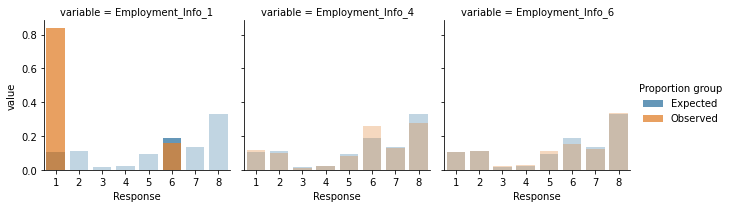

In [27]:
f = pd.concat((
    train_df["Response"],
    train_df[train_df.columns[np.where(train_df.isnull().sum(axis=0) > 0)]].isnull().astype(float)
), axis=1).groupby("Response").sum()
f = f / f.sum(axis=0)
f = f.join(train_df["Response"].value_counts().sort_index().to_frame().rename(columns={"index": "Response", "Response": "Expected"}))
f["Expected"] /= f["Expected"].sum()
f = pd.melt(f.reset_index(), id_vars=["Response", "Expected"], value_vars=f.columns[:-1], value_name="Observed").iloc[:, [0, 2, 1, 3]].reset_index()
# f = pd.melt(f, id_vars=["Response", "Proportion_exp"],
f = pd.merge(
    f.loc[:, f.columns[:3]],
    pd.melt(f, id_vars=["index"], value_vars=["Expected", "Observed"], var_name="proportion_gp"),
    on="index", how="left")
f = f[f.columns[1:]]
for x in [
        "Employment_Info",
#         "Insurance_History",
#         "Family_Hist",
#         "Medical_History"
        ]:
    g = sns.FacetGrid(
        f.loc[f["variable"].str.contains(x)].rename(columns={"proportion_gp": "Proportion group"}), 
        col="variable", 
        hue="Proportion group",
        col_wrap=f["variable"][f["variable"].str.contains(x)].nunique()
#         col_wrap=5
    )
    g.map(sns.barplot, "Response", "value", order=list(range(1, 9)), alpha=.75)
    g.add_legend()
    if x == "Employment_Info":
        for i in range(3):
            for j, bar in enumerate(g.axes[i].get_children()[:16]):
                if not (i==0 and j in [0, 5, 8, 13]):
                    bar.set_alpha(.3)

We now shift our focus onto the *missingness* in variables related to employment information. Similarly, the blue histogram indicates the proportion of *missing* values of each risk level in terms of the whole training set. The orange histogram shows the proportion of *missing* values of each risk level in terms of the non-missing samples of the variable the histogram is representing. 

Although the variable 'Employment_Info_1' has only 19 missing values, it is still worth noting the significant difference in terms of the proportion. If we observe someone *not* filling in values in this variable, it is very likely that the individual has risk level 1.

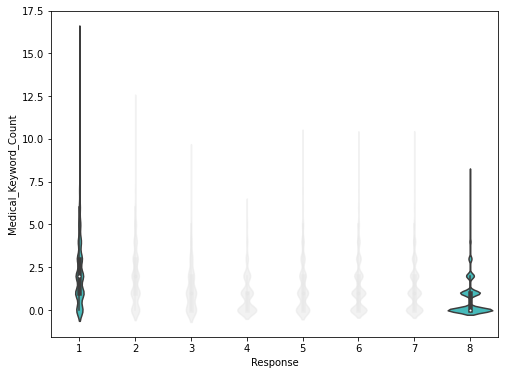

In [198]:
plt.figure(figsize=(8, 6))
g = sns.violinplot(
    x="Response",
    y="Medical_Keyword_Count",
    data=pd.concat((train_df["Response"], train_df[dummy].sum(axis=1).rename("Medical_Keyword_Count")), axis=1),
    ax=plt.gca()
)

for i in range(11):
    g.get_children()[2+i].set_color((.9,.9,.9,.5))
    g.get_children()[3+i].set_color((.9,.9,.9,.5))
    g.get_children()[18+i].set_color((.9,.9,.9,.5))
    g.get_children()[19+i].set_color((.9,.9,.9,.5))
g.get_children()[0].set_facecolor((.2,.7,.7,.9))
g.get_children()[14].set_facecolor((.2,.7,.7,.9))

        

Variables Medical_Keyword_1-48 are one-hot variables that indicate the presence of certain medical keywords. I am not saying having any medical keywords in your form is bad. But, do you think it is good for you to have so many medical keywords present in your form? Having more medical keywords is very likely to be associated of presence of *problems*/*symptoms*/*diseases* in someone's body.

Thus, it is natural for us to assume that the number of medical keywords that an applicant has in his/her form is related to his/her health status. We may assume, if the applicant has more medical keywords than the average, it is more likely for him/her to have a bad health status and, a higher risk of course.

The figure is a violin plot that shows the distribution of number of medical keywords from the risk assessment forms. Each violin corresponds to different risk level. Let us focus again on risk levels 1 and 8. It is clear that the violin body of risk level 8 is fatter at zero medical keywords. The highest number of medical keywords the violin neck can get is around 8. However, the violin body of risk level 1 is much slimmer, indicating the number of medical keywords in risk level 1 varies more than that in risk level 8. The highest number of medical keywords the violin neck of risk level 1 can get is around 17.5, almost a double of the maximum reach of risk level 8.

Compared to the forms with risk level 8, those with risk level 1 are more likely to have more than one medical keyword. So, this indicates that the number of medical keywords is associated with risk level 1.

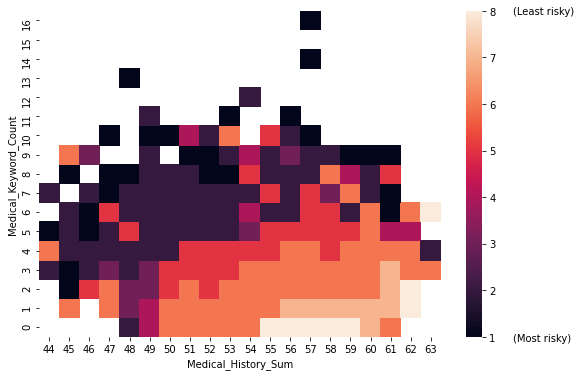

In [197]:
f = pd.concat((
    train_df["Response"], 
    train_df[[x for x in nominal if "Medical_History" in x and "_2" not in x]].sum(axis=1).rename("Medical_History_Sum"),
    train_df[dummy].sum(axis=1).rename("Medical_Keyword_Count")
), axis=1).groupby(["Medical_Keyword_Count", "Medical_History_Sum"]).median().reset_index()
f_heatmap = np.full((f["Medical_Keyword_Count"].max()+1, np.ptp(f["Medical_History_Sum"])+1), 8)
f_mask = np.ones_like(f_heatmap, dtype=int)
for tp in f.itertuples():
    f_heatmap[tp.Medical_Keyword_Count, tp.Medical_History_Sum - f["Medical_History_Sum"].min()] = tp.Response
    f_mask[tp.Medical_Keyword_Count, tp.Medical_History_Sum - f["Medical_History_Sum"].min()] = 0
plt.figure(figsize=(9, 6))
g = sns.heatmap(
    f_heatmap,
    mask=f_mask,
    xticklabels=range(f["Medical_History_Sum"].min(),
                      f["Medical_History_Sum"].max()+1),
    ax=plt.gca()
)
g.invert_yaxis()
label_offset = .0067
g.annotate("(Least risky)", (1.18, .982+label_offset), xycoords="axes fraction")
g.annotate("(Most risky)", (1.18, -.02+label_offset), xycoords="axes fraction")
plt.xlabel("Medical_History_Sum")
_ = plt.ylabel("Medical_Keyword_Count")

We ignore variable 'Medical_History_2' in all nominal variables related to medical history because this variable has way too many possible values. It is possible that the integer in 'Medical_History_2' represents certain *combination* but we have no evidence for this. Anyway, apart from this variable, all the other 35 variables related to medical history have at most 3 levels (in training set and test set).